In [18]:
#import Labraries 
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchsummary import summary



In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
#train and test path 
train_data = "/home/hasan/Rasool_Folder/Datasets/Arabic-HhandWritten-Digits/train"
test_data = "/home/hasan/Rasool_Folder/Datasets/Arabic-HhandWritten-Digits/test"

In [4]:
#load the train and test data and conver them to tensors
train_dataset = ImageFolder(train_data,transform = transforms.Compose([
    transforms.ToTensor(),transforms.Grayscale()
]))
test_dataset = ImageFolder(test_data,transforms.Compose([
    transforms.ToTensor(),transforms.Grayscale()
]))

In [5]:
#display train data classes

train_dataset.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [6]:
#display test data classes

test_dataset.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [7]:
#display the data shape

img, label = train_dataset[0]
img.shape,label

(torch.Size([1, 28, 28]), 0)

In [8]:
len(train_dataset)

59500

In [9]:
len(test_dataset)

10000

In [10]:
#split the train data into train and validation
batch_size = 128
val_size = 10000
train_size = len(train_dataset) - val_size 

train_data,val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 49500
Length of Validation Data : 10000


In [11]:
#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 2, pin_memory = True)

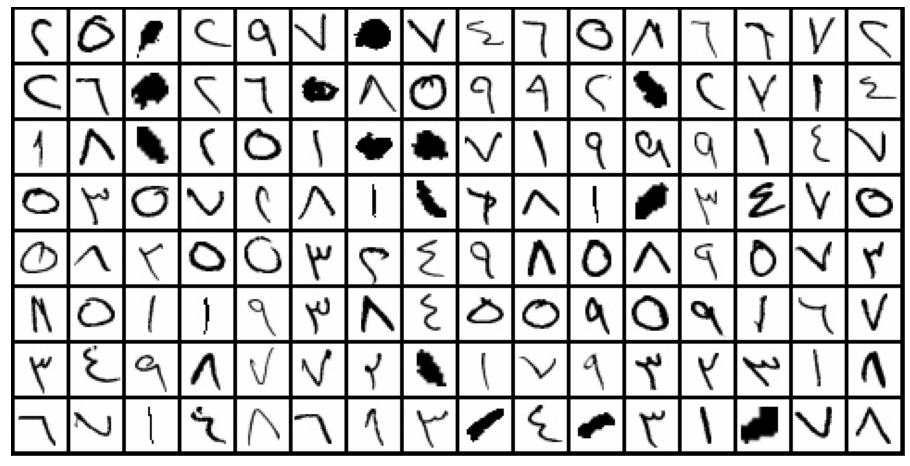

In [13]:
#display images batch 
def display_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
display_batch(train_dl)

In [15]:

import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:

class HandWrittenNetwork(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16,32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
           
            nn.Flatten(),
            nn.Linear(1568,725),
            nn.ReLU(),
            nn.Linear(725,10)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [17]:
model = HandWrittenNetwork()
model

HandWrittenNetwork(
  (network): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=725, bias=True)
    (10): ReLU()
    (11): Linear(in_features=725, out_features=10, bias=True)
  )
)

In [19]:
# display the model summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HandWrittenNetwork().to(device)
summary(model,(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Conv2d: 2-1                       [-1, 16, 28, 28]          160
|    └─ReLU: 2-2                         [-1, 16, 28, 28]          --
|    └─Conv2d: 2-3                       [-1, 32, 28, 28]          4,640
|    └─ReLU: 2-4                         [-1, 32, 28, 28]          --
|    └─MaxPool2d: 2-5                    [-1, 32, 14, 14]          --
|    └─Conv2d: 2-6                       [-1, 32, 14, 14]          9,248
|    └─ReLU: 2-7                         [-1, 32, 14, 14]          --
|    └─MaxPool2d: 2-8                    [-1, 32, 7, 7]            --
|    └─Flatten: 2-9                      [-1, 1568]                --
|    └─Linear: 2-10                      [-1, 725]                 1,137,525
|    └─ReLU: 2-11                        [-1, 725]                 --
|    └─Linear: 2-12                      [-1, 10]                  7,26

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Conv2d: 2-1                       [-1, 16, 28, 28]          160
|    └─ReLU: 2-2                         [-1, 16, 28, 28]          --
|    └─Conv2d: 2-3                       [-1, 32, 28, 28]          4,640
|    └─ReLU: 2-4                         [-1, 32, 28, 28]          --
|    └─MaxPool2d: 2-5                    [-1, 32, 14, 14]          --
|    └─Conv2d: 2-6                       [-1, 32, 14, 14]          9,248
|    └─ReLU: 2-7                         [-1, 32, 14, 14]          --
|    └─MaxPool2d: 2-8                    [-1, 32, 7, 7]            --
|    └─Flatten: 2-9                      [-1, 1568]                --
|    └─Linear: 2-10                      [-1, 725]                 1,137,525
|    └─ReLU: 2-11                        [-1, 725]                 --
|    └─Linear: 2-12                      [-1, 10]                  7,26

In [20]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
# load the model into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

HandWrittenNetwork(
  (network): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=725, bias=True)
    (10): ReLU()
    (11): Linear(in_features=725, out_features=10, bias=True)
  )
)

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.Adam):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [25]:
#load the model to the device
model = to_device(HandWrittenNetwork(),device)

In [27]:
#Hyperparameters 
epochs = 30
optimizer = torch.optim.Adam
lr = 0.001

In [28]:
#training our model
history = fit(epochs, lr, model, train_dl, val_dl, optimizer)

Epoch [0], train_loss: 0.1996, val_loss: 0.0534, val_acc: 0.9843
Epoch [1], train_loss: 0.0370, val_loss: 0.0342, val_acc: 0.9894
Epoch [2], train_loss: 0.0254, val_loss: 0.0284, val_acc: 0.9903
Epoch [3], train_loss: 0.0190, val_loss: 0.0268, val_acc: 0.9913
Epoch [4], train_loss: 0.0157, val_loss: 0.0263, val_acc: 0.9925
Epoch [5], train_loss: 0.0130, val_loss: 0.0245, val_acc: 0.9919
Epoch [6], train_loss: 0.0112, val_loss: 0.0236, val_acc: 0.9929
Epoch [7], train_loss: 0.0108, val_loss: 0.0246, val_acc: 0.9925
Epoch [8], train_loss: 0.0086, val_loss: 0.0208, val_acc: 0.9935
Epoch [9], train_loss: 0.0086, val_loss: 0.0254, val_acc: 0.9937
Epoch [10], train_loss: 0.0070, val_loss: 0.0272, val_acc: 0.9933
Epoch [11], train_loss: 0.0057, val_loss: 0.0291, val_acc: 0.9934
Epoch [12], train_loss: 0.0071, val_loss: 0.0307, val_acc: 0.9917
Epoch [13], train_loss: 0.0051, val_loss: 0.0277, val_acc: 0.9939
Epoch [14], train_loss: 0.0042, val_loss: 0.0408, val_acc: 0.9922
Epoch [15], train_lo

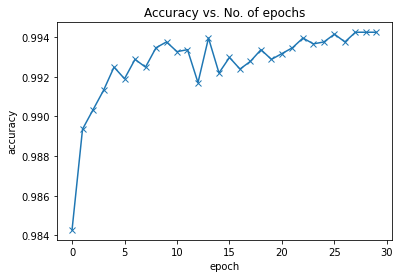

In [29]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

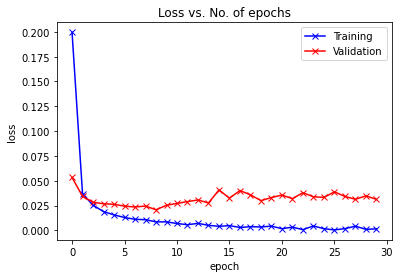

In [30]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [31]:
# Apply the model on test dataset and Get the results
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.05702627822756767, 'val_acc': 0.9917968511581421}